# I. Monte-Carlo for some multiplicative free convolutions.

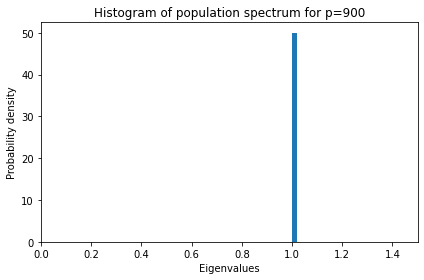

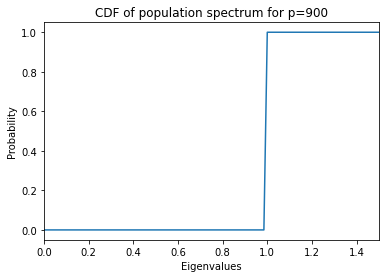

Sampling... 


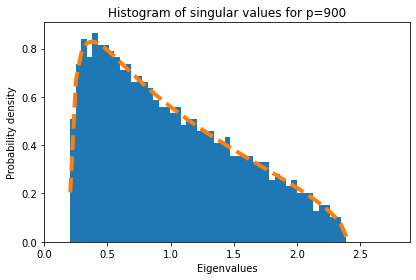

In [1]:
import time
import scipy
import numpy as np
import matplotlib.pyplot as plt

N=3000
num_bins=50

Scenario = "Case1"

# Initiate scenario
import freeDeconvolution

c, p, population_spectrum, interval_cdf, population_cdf = freeDeconvolution.scenarios.initiate_scenario( Scenario, N)
r = (1+np.sqrt(c))**2 #Right end of MP
l = (1-np.sqrt(c))**2 #Left end of MP

freeDeconvolution.plots.plot_population( population_spectrum, num_bins, interval_cdf, population_cdf, plt )

# Sample
print( "Sampling... ")
diag = freeDeconvolution.sampling.sample_wishart( p, N, population_spectrum )

freeDeconvolution.plots.plot_observed_spectrum( Scenario, c, diag, num_bins, plt)

# II. Cauchy-Stieljes transform: Empirical vs Theoretical

For convenience, let us compute:
$$ G(z) = \int_\mathbb{R} \frac{\mu_{MP}(dt)}{z-t}$$

The formula is
$$ G(z) = \frac{z-1+c - \sqrt{ (z-1-c)^2 - 4c} }{2z \ c}$$
In particular
$$ M(z) = z G(z) - 1 = \frac{1}{2c} ( z-1-c - \sqrt{ (z-1-c)^2 - 4c} )$$
which solves the quadratic equation:
$$ c*m^2 - (z-1-c)*m + 1 = 0$$
or equivalently
$$ m z = m(1 + c) + c*m^2 + 1
       = c(m+1)(m+1/c)
$$
or equivalently
$$
   s = (1+m)/(m*z)
     = 1/(cm+1)
$$


(1+1j)
(0.03133459861834979-0.8095179405560436j)
(0.031188992911404197-0.8091687765720551j)


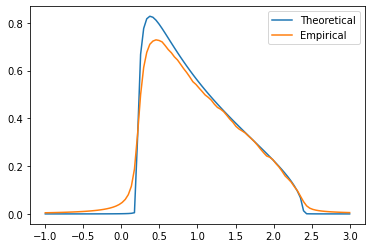

In [8]:
# Warning: This has changed to fit El Karoui's Case 1
def G_theoretical(z):
    sqrt = np.sqrt( (z-c-1)*(z-c-1)-4*c )
    positive_imag = (np.imag(sqrt)>0)
    sqrt = positive_imag*sqrt - (1-positive_imag)*sqrt
    #res = (z+c-1-sqrt)/(2*c*z)-2/(c*z)
    #return res*c
    #return (z-c+1-sqrt)/(2*z*c)
    return (z+c-1-sqrt)/(2*z*c)

mu_observed = freeDeconvolution.core.DiscreteMeasure( diag, None)

z0 = np.array( complex(1.0+1.0j) )
print(z0)
print( G_theoretical(z0) )
print( mu_observed.G_empirical(z0) )

if Scenario=='Case1':
    interval = np.linspace(-1, 3, 100)
    density1 = -np.imag( G_theoretical(interval+0.001j) )/np.pi
    density2 = -np.imag( mu_observed.G_empirical(interval+0.05j) )/np.pi
    plt.plot( interval, density1, label='Theoretical')
    plt.plot( interval, density2, label='Empirical')
    plt.legend()
    plt.show()

### II. 1. Zeroes of the second kind

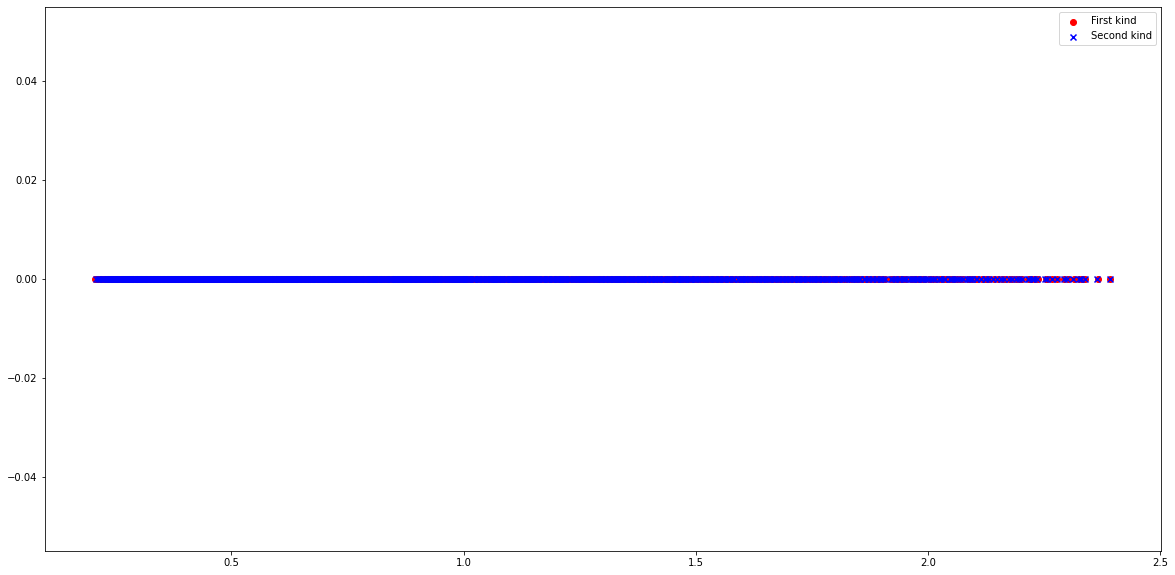

In [3]:
mu_observed.compute_second_kind()

zeroes_first_kind   = mu_observed.zeroes_first_kind
zeroes_second_kind  = mu_observed.zeroes_second_kind

# Plotting
plt.figure( figsize=(20,10) )
plt.scatter( np.real( zeroes_first_kind  ), np.imag( zeroes_first_kind  ), c='r', label='First kind')
plt.scatter( np.real( zeroes_second_kind ), np.imag( zeroes_second_kind ), marker='x', c='b', label='Second kind')
plt.legend()
plt.show()

### II. 2. Argument principle for locating branch points

Eigenvalues
min:  0.20748698010740377
max:  2.391306965268235


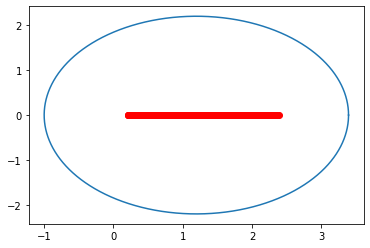

Index:  (-2.000026265096414+6.537806845230562e-16j)
Root count:  (1797.9999737349035+6.537806845230562e-16j)


In [4]:
degree = len(diag)

print("Eigenvalues")
print("min: ", np.min(diag))
print("max: ", np.max(diag))

mesh_size = 10000
radius = np.max(diag)/2 + 1
center = np.max(diag)/2
interval = np.linspace(0, 2*np.pi, mesh_size)
contour = center + radius*( np.cos(interval) + np.sin(interval)*1.0j)
plt.scatter( np.real(diag), np.imag(diag), c='r')
plt.plot( np.real(contour), np.imag(contour) )
plt.show()

def index_integrand(z):
    values = mu_observed.Markov_Krein_prime(z)/mu_observed.Markov_Krein(z)
    return values

values = index_integrand(contour)
dz = 1.0j*(contour-center)*2*np.pi/(mesh_size) 
index  = np.sum(dz*values)/(2*np.pi*1.0j)
print( "Index: ", index)
print( "Root count: ", index+2*degree)


In [5]:
from freeDeconvolution import boxes

print( "Box segments enumeration: ")
print( boxes.box_segments_enum )

def compute_index( box, mesh_size, plot=True, color='b'):
       interval =  np.linspace( 0,1, mesh_size)
       integral = 0
       for segment in boxes.box_segments_enum:
              vector = box[ segment[1] ] - box[ segment[0] ]
              origin = box[ segment[0] ]
              s = origin + interval*vector
              #
              values = index_integrand(s)
              dz = ( s[-1]-s[0] )/mesh_size
              integral = integral + np.sum( values*dz )
       return integral/(2*np.pi*1.0j)

Box segments enumeration: 
[('bottom_right', 'top_right'), ('top_right', 'top_left'), ('top_left', 'bottom_left'), ('bottom_left', 'bottom_right')]


In [6]:
# TODO: Make it more versatile. Here tuning by hand of radius.
print("Finding bounding box...")

radius = 2
mesh_size = int(1e4)
bounding_box = {
       'top_left'    : np.min(diag) - 1 + radius*1.0j,
       'bottom_right': np.max(diag) + 1 - radius*1.0j,
}
bounding_box   = boxes.extend_box(bounding_box)
index = compute_index( bounding_box, mesh_size)
index = np.real(index+2*degree)
root_count = int( np.round( index ) )
error = index-root_count
print( "Index     : ", index)
print( "Root count: ", "2x", 0.5*root_count)
print( "p         : ", p)
print( "")

Finding bounding box...
Index     :  1798.0000746583437
Root count:  2x 899.0
p         :  900



In [ ]:
# Plotting
plt.figure( figsize=(20,10) )
boxes.plot_box( bounding_box, mesh_size, 'b', plt)
plt.scatter( np.real(diag), np.imag(diag), c='r')
plt.show()

In [ ]:
box = bounding_box.copy()
box['bottom_left'] = box['top_left'] # For initialization, bottom_left needs to be the previous top_left
radius = box['height']/2
stop_at_first_nonempty = False        # Stop at first found box with roots

# Loop for multiple passes and more
boxes_with_roots = []
root_counter = 0
total_roots  = p-1 # Total number of roots in upper half plane
i = 0
while( root_counter < total_roots ):
       i = i+1
       print(f"Pass {i}:")
       radius = radius/2
       box = {
              'top_left'    : box['bottom_left'],
              'bottom_right': np.max(diag) + 1 + radius*1.0j,
       }
       box   = boxes.extend_box(box)
       index = compute_index( box, mesh_size, plot=False)
       index = np.real(index)
       root_count = int( np.round( index ) )
       root_counter = root_counter + root_count
       error = index-root_count
       print( "Index: ", index)
       print( "Root count / Total: ", root_count, '/', root_counter)
       print( "Found:", root_counter, " / ", total_roots )
       print( "")
       #
       if root_count>0:
              box['root_count'] = root_count
              boxes_with_roots.append( box )
              if stop_at_first_nonempty:
                     break
#

In [ ]:
print("There are ", len(boxes_with_roots), "large boxes containing zeroes.")

# Plotting
for box in boxes_with_roots:
       color = np.random.rand(3)
       boxes.plot_box( box, mesh_size, color, plt)
plt.scatter( np.real(diag), np.imag(diag), c='r')
plt.show()

# III. Dichotomy in the complex plane

In [ ]:
def refine_boxes( coarse_boxes, debug=False ):
    refined_boxes = []
    for box in coarse_boxes:
        split_boxes = boxes.split_box( box )
        #
        for refined_box in split_boxes:
            index = compute_index( refined_box, mesh_size, plot=False)
            index = np.real(index)
            root_count = int( np.round( index ) )
            error = index-root_count
            if debug:
                print("Error: ", error)
            if root_count>0:
                refined_box['root_count'] = root_count
                refined_boxes.append( refined_box )
    return refined_boxes

def refine_single_box_once( coarse_box ):
    box1, box2 = boxes.split_box( box )
    #
    index1 = compute_index( box1, mesh_size, plot=False)
    index2 = compute_index( box2, mesh_size, plot=False)
    index1 = np.real(index1)
    index2 = np.real(index2)
    error1 = abs(index1-1)
    error2 = abs(index2-1)
    if error1 < error2:
        return box1
    else:
        return box2

def refine_single_box( box_, tol=1e-5):
    result = box_
    while boxes.box_radius(result) > tol:
        result = refine_single_box_once( result )
    return result

In [ ]:
#refined_boxes = boxes_with_roots
# boxes_with_many_roots = [ boxes_with_roots[0] ]
boxes_with_many_roots = boxes_with_roots
refined_boxes = []
print("Pass / Number of refined boxes / Remaining roots:")
i = 1
mesh_size = int(1e3)
while len( boxes_with_many_roots ) > 0:
    new_boxes = refine_boxes( boxes_with_many_roots )
    boxes_with_many_roots = [ box for box in new_boxes if box['root_count']>1]
    boxes_with_one_root   = [ box for box in new_boxes if box['root_count']<=1]
    refined_boxes = refined_boxes + boxes_with_one_root
    counts = [ box['root_count'] for box in boxes_with_many_roots]
    total_count = np.sum(counts)
    print( i, ": ", len(refined_boxes), " / ", total_count )
    i = i + 1
# end while
print("")

In [ ]:
# More dichotomy refining
print("Dichotomy refining for single boxes")
very_refined_boxes = []
i = 0
for box in refined_boxes:
    i = i+1
    # box = refine_single_box( box )
    while boxes.box_radius(box) > 1e-5:
        box = refine_single_box_once( box )
    print( "Refined box ", i)
    very_refined_boxes.append( box )

In [ ]:
# Plotting
# plt.figure( figsize=(20,10) )
# for box in very_refined_boxes:
#        color = np.random.rand(3)
#        boxes.plot_box( box, mesh_size, color, plt)
# plt.scatter( np.real(diag), np.imag(diag), marker='*', c='r', label=f'Eigenvalues (N={N})')
# plt.title( 'Eigenvalues and estimation of branching points')
# plt.legend()
# plt.show()

In [ ]:
def point_inside( box, z):
    distance = np.abs( z-boxes.box_midpoint(box) )
    return (distance < 1e-3)

critical_points = []
errors = []
for box in very_refined_boxes:
    midpoint = boxes.box_midpoint( box )
    z = freeDeconvolution.utils.newton_raphson( mu_observed.Markov_Krein, mu_observed.Markov_Krein_prime, midpoint)
    if point_inside( box, z):
        critical_points.append( z )
        errors.append( abs(mu_observed.Markov_Krein(z)) )
critical_points = np.array( critical_points )
branch_points = mu_observed.M_empirical( critical_points )
errors = np.array( errors )

print( "Max error:", np.max(errors) )
sorted_indices = np.argsort(errors)
print( "Errors:   ", errors[sorted_indices] )

# Plotting critical points
def normalize( array ):
    min = np.min( array )
    max = np.max( array )
    return (array-min)/(max-min)
def transport_to_uniform( array ):
    uniform_sample = np.linspace( 0, 1, len(array))
    sorted_indices = np.argsort( array )
    return uniform_sample[ sorted_indices ]
critical_points_color = transport_to_uniform( np.abs( branch_points ) )
plt.figure( figsize=(20,10) )
plt.scatter( np.real(critical_points), np.imag(critical_points), marker='*', c=critical_points_color, label=f'Critical points (p-1={p-1})')
plt.scatter( np.real(zeroes_first_kind), np.imag(zeroes_first_kind), marker='*', c='r', label=f'Eigenvalues (p={p})')
plt.scatter( np.real(zeroes_second_kind), np.imag(zeroes_second_kind), marker='*', c='b', label=f'Zeroes of the second kind (p-1={p-1})')
plt.title( 'Eigenvalues and critical points')
plt.legend()
plt.colorbar()
plt.show()

# Plotting branch points
## Transport colors to uniform
branch_points_color = transport_to_uniform( np.abs( np.imag( critical_points ) ) )
## Plots as usual
plt.figure( figsize=(10,20) )
plt.scatter( np.real(branch_points),  np.imag(branch_points), marker='*', c=branch_points_color, label=f'Branch points (p-1={p-1})')
plt.scatter( np.real(branch_points), -np.imag(branch_points), marker='x', c=branch_points_color, label=f'(Conjugate) Branch points (p-1={p-1})')
plt.title( 'Branch points $m = M_\mu(z)$')
plt.legend()
plt.colorbar()
plt.show()

In [ ]:
# Saving data
path_prefix = './data/' + Scenario + '_'
with open(path_prefix + 'first_kind.npy', 'wb') as f:
    np.save(f, zeroes_first_kind)
with open(path_prefix + 'second_kind.npy', 'wb') as f:
    np.save(f, zeroes_second_kind)
with open(path_prefix + 'critical_points.npy', 'wb') as f:
    np.save(f, critical_points)
with open(path_prefix + 'branch_points.npy', 'wb') as f:
    np.save(f, branch_points)